In [1]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)

Skipping install of 'rwwa' from a github remote, the SHA1 (0707feb5) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot


Loading required package: plyr


Attaching package: ‘plyr’


The following object is masked from ‘package:distillery’:

    is.formula




# Trend fitting - observations

## Univariate analysis

In [5]:
datasets <- c("chirps","era5land", "mswep", "acp-filled-allstations-1979", "acp-filled-allstations-1950", "acp-filled-allstations")

### Fit models

In [6]:
# load covariate data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [7]:
nsamp <- 1000
for (ds in datasets) {
    
    fnm <- paste0("ts/panama_pr-rs_",ds,".dat")
    
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        res <- boot_ci(mdl, cov_f = cov_2023, cov_cf = cov_cf, nsamp = nsamp)
        
        # get correlation between Nino3.4 and rainy season precip, for evaluation
        set.seed(42)
        nino_corr <- c(cor(df$nino, df$pr), quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino", "pr")])[1,2]), c(0.025, 0.975)))
                                                   
        write.csv(rbind(res, nino_corr), res_fnm)
    }
}

### Compile results for synthesis

In [15]:
obs_res <- data.frame(t(sapply(datasets, function(ds) {
    res <- read.csv(paste0("res/res_panama_pr-rs_",ds,".csv"), row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
})))

# select the critical columns & save as a single .csv
write.csv(obs_res[,rowSums(sapply(c("disp", "shape", "return.period", "PR", "dI.rel"), grepl, colnames(obs_res))) == 1],
          "res_pr-rs_gmst-nino_obs.csv")

### Parameter estimates

In [36]:
# load all the bootstrapped results
res_rs <- abind::abind(sapply(datasets, function(ds) {
    read.csv(paste0("res/res_panama_pr-rs_",ds,".csv"), row.names = "X")
}, simplify = F), along = 0)
res_rs[c("era5land"),"return_period",] <- NA

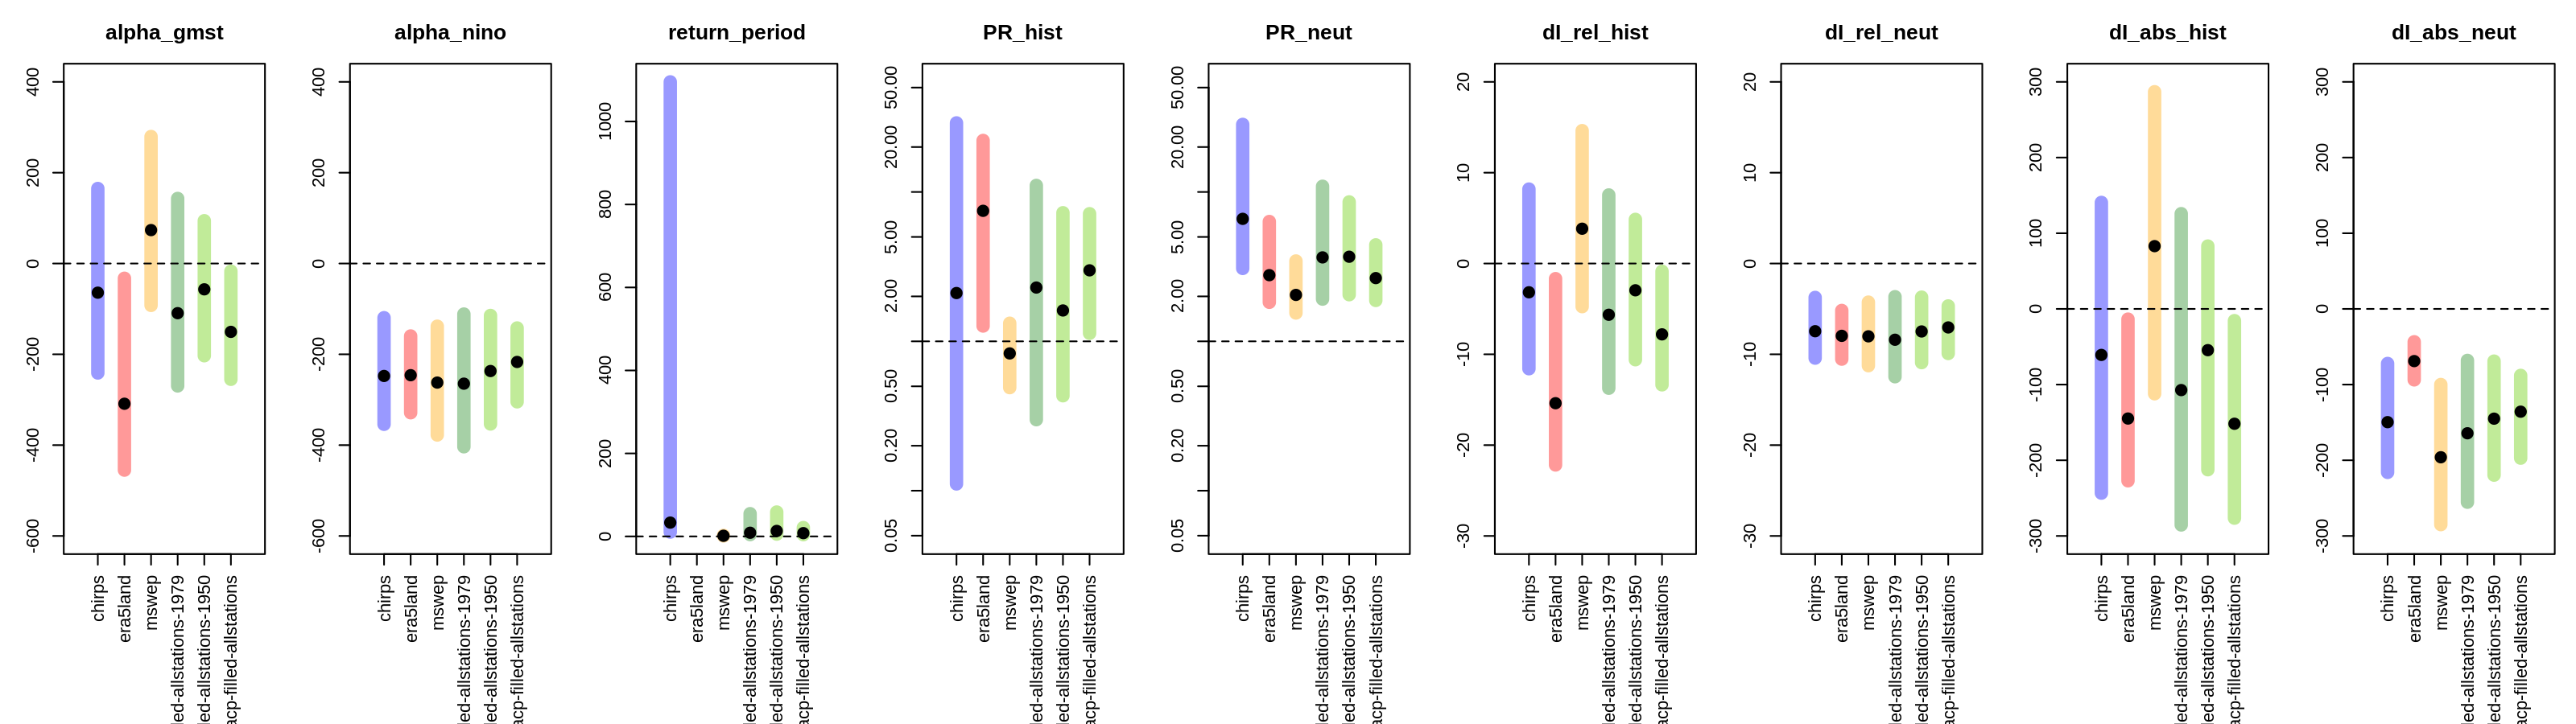

In [38]:
plot_pars <- c("alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- res_rs[,r,]
        ylim = range(res, na.rm = T)
        logaxs = ""
        h = 0
        
        n <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(res_rs[,grepl("alpha", colnames(res_rs)),]))
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(res_rs[,grepl("dI_abs", colnames(res_rs)),]))
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(res_rs[,grepl("dI_rel", colnames(res_rs)),]))
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(res_rs[,grepl("PR", colnames(res_rs)),]))))
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"X2.5."], y1 = res[,"X97.5."], lwd = 8, col = adjustcolor(c("blue", "red", "orange", "forestgreen", "chartreuse3", "chartreuse3"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }

In [39]:
# find return period to be used in model evaluation
res_rs[,"return_period",]

,est,X2.5.,X97.5.
chirps,33.292927,10.419287,1095.422775
era5land,NA,NA,NA
mswep,1.503109,1.133397,2.447626
acp-filled-allstations-1979,8.807910,4.377940,54.798695
acp-filled-allstations-1950,13.186605,5.551294,58.765439
acp-filled-allstations,7.871176,4.175858,21.259950


### Unconditional return periods

## Per grid cell

In [7]:
ds <- "era5land"

nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df <- read.csv(paste0("data/",ds,"_pr-MJJASOND_flattened.csv"), skip = 3, header = F)
colnames(df)[1] <- "year"

df <- merge(merge(nino, gmst), df)

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [8]:
# fit nonstationary model to all grid cells
models <- sapply(colnames(df)[-(1:3)], function(cnm) {
    df_c <- df[,c("year", "gmst", "nino", cnm)]
    fit_ns("norm", "fixeddisp", df_c, cnm, c("gmst", "nino"), lower = T)
}, simplify = F)

In [9]:
# get all model resuls & save as .csv to be reconstructed & plotted in python
fitted_res <- sapply(models, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
fitted_res <- rbind(fitted_res, rp_neut = sapply(models, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop=F])))
write.csv(fitted_res, paste0("res/res_rs_",ds,"-gridded.csv"))

## Individual stations

In [5]:
# load covariate data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

### Filled stations

In [13]:
# specify period to fit model to
ys <- 1925

# load station data, combine with covariates in single dataframe
pr <- read.csv("data/acp-filled_pr-rs.csv", row.names = "Date")
pr$year <- rownames(pr)
df <- merge(merge(gmst, nino), pr)

In [14]:
# fit all the models
models <- list()
for(stn in colnames(df)[-(1:3)]) {
    df_stn <- df[df$year >= ys,c("year", "gmst", "nino", stn)]
    models[[stn]] <- fit_ns("norm", "fixeddisp", df_stn, stn, c("gmst", "nino"), lower = T)
}

# get all the best estimates & save as single file
res <- sapply(models, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
res <- rbind(res, rp_neut = sapply(models, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop = F])))
write.csv(res, paste0("res/res_rs_stations-filled_",ys,"-2023.csv"))

### Mostly-complete stations

In [15]:
# specify period to fit model to
ys <- 1925

# load station data, combine with covariates in single dataframe
pr <- read.csv("data/acp-complete_pr-rs.csv", row.names = "X")
pr$year <- rownames(pr)
df <- merge(merge(gmst, nino), pr)

# filter to only required period
df <- df[df$year >= ys,]

# select only stations with more than 90% complete years
complete_stations <- names(which(colSums(!is.na(df[,-(1:3)])) > ceiling((2023-ys) * .9)))
df <- df[,c("year", "gmst", "nino", complete_stations)]

In [16]:
# fit models to the available data
models <- list()
for(stn in colnames(df)[-(1:3)]) {
    df_stn <- df[df$year >= ys,c("year", "gmst", "nino", stn)]
    models[[stn]] <- fit_ns("norm", "fixeddisp", df_stn[!is.na(df_stn[,stn]),], stn, c("gmst", "nino"), lower = T)
}

# get all the best estimates & save as single file
res <- sapply(models, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
res <- rbind(res, rp_neut = sapply(models, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop = F])))
write.csv(res, paste0("res/res_rs_stations-complete_",ys,"-2023.csv"))

### Compare results when using complete years vs gap-filled data

In [19]:
ys <- 1979

res_complete <- read.csv(paste0("res/res_rs_stations-complete_",ys,"-2023.csv"), row.names = "X")
res_filled <- read.csv(paste0("res/res_rs_stations-filled_",ys,"-2023.csv"), row.names = "X")

# find stations that appear in both datasets, combine into a single array of all results
stations <- names(which(sapply(colnames(res_complete), function(cnm) cnm %in% colnames(res_filled))))
                               
res_all <- abind::abind("complete" = res_complete[,stations], "filled" = res_filled[,stations], along = 0)

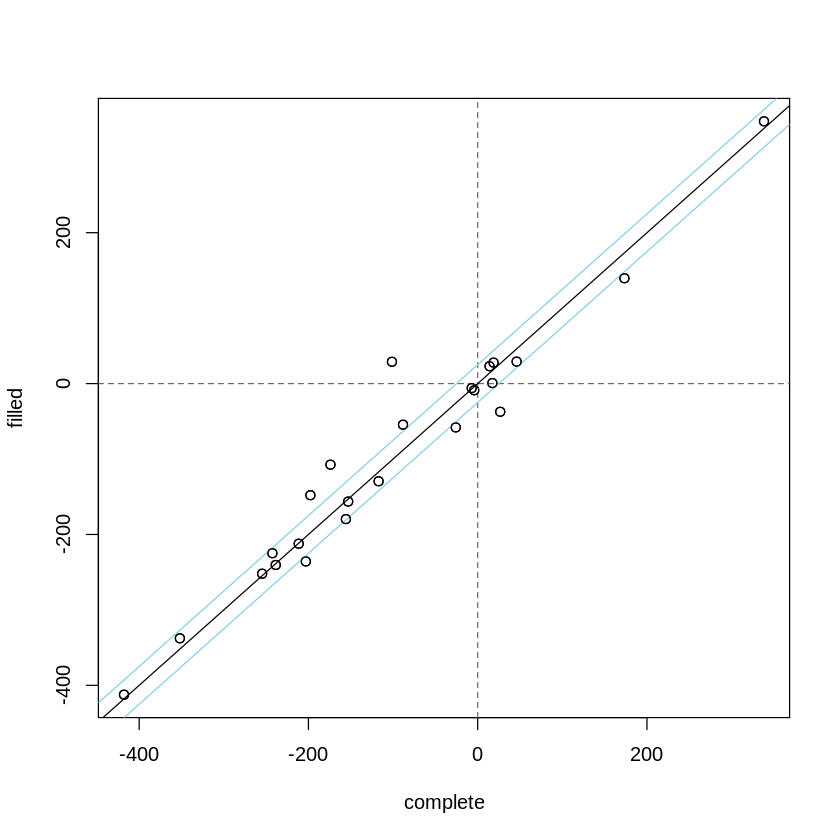

In [39]:
plot(t(res_all[,"alpha_gmst",]))
abline(h = 0, v = 0, lty = 2, col = "dimgrey")

abline(0,1); abline(25,1, col = "skyblue"); abline(-25,1, col = "skyblue")
points(t(res_all[,"alpha_gmst",]))

# Trend fitting - climate models

## GMST + Nino3.4

In [2]:
rp = 10
nsamp = 1000

# standardise Nino to have mean 0 and sd 1 over 1979-2023
nino_obs <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
nino_1979 <- nino_obs$nino[nino_obs$year >= 1979]
nino_obs$nino <- (nino_obs$nino - mean(nino_1979)) / sd(nino_1979)

# use 2023 standardised Nino as covariate
nino_2023 <- nino_obs$nino[nino_obs$year == 2023]

# currently no Nino data for EC-EARTH
fl <- list.files("ts", pattern = "wetseason_.AM-[0-9]{2}", full.names = T)
fl <- fl[!grepl("EC-EARTH", fl)]

In [3]:
for (fnm in fl) {
    
    nino_fnm <- list.files("ts", pattern = paste0("nino-rs_", paste0(strsplit(fnm, "_")[[1]][4:5], collapse = "_")), full.names = T)
    if(length(nino_fnm) == 0) next

    # load data & fit model
    ts <- load_ts(fnm, col.names = c("year", "pr"))
    gmst <- load_ts(list.files("ts", pattern = paste0("smoothed-gsat_", strsplit(fnm, "_")[[1]][4]), full.names = T), col.names = c("year", "gmst"))
    nino <- load_ts(nino_fnm, col.names = c("year", "nino"))
    
    # combine all covariates with time series
    df <- merge(ts, merge(gmst, nino))
    
    mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)

    res_fnm <- gsub("pr-wetseason", "pr-wetseason-nino", gsub(".dat", ".csv", gsub("ts/", "res/", fnm)))
    if(!file.exists(res_fnm)) {
        
        # use model's 2023 GMST & observed Nino to define factual climate
        gmst_2023 <- df$gmst[df$year == 2023]
        
        cov_2023 <- data.frame(gmst = gmst_2023, nino = nino_2023)
        cov_cf <- rbind("pi" = data.frame("gmst" = gmst_2023 - 1.2, "nino" = nino_2023), 
                        "neut" = data.frame("gmst" = gmst_2023, "nino" = 0))
        cov_fut <- data.frame(gmst = gmst_2023 + 0.8, nino = nino_2023)

        # bootstrap results
        res <- cmodel_results(mdl, rp = rp, cov_f = cov_2023, cov_hist = cov_cf, cov_fut = cov_fut,
                             y_now = 2023, y_start = 1979, y_fut = 2050, nsamp = nsamp)
        
        # bootstrap correlation between Nino & precip in this region
        set.seed(42)
        nino_corr <- c(cor(df$nino, df$pr), 
                       quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino", "pr")])[1,2]), c(0.025, 0.975)))
        nino_corr <- setNames(data.frame(t(nino_corr)), paste0("nino-corr_", c("est", "lower", "upper")))
                                       
        res <- cbind(nino_corr, res)
        write.csv(res, res_fnm)
    }
                                       
    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res/", "mdl-eval/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 480, w = 480 * 2); par(cex.main = 1.4, mfrow = c(1,2), oma = c(0,0,2,0)); {
            plot_returnlevels(mdl, cov_f = cov_2023, cov_cf = cov_cf["pi",,drop = F], nsamp = 100, main = "Present vs PI")
            plot_returnlevels(mdl, cov_f = cov_2023, cov_cf = cov_cf["neut",,drop = F], nsamp = 100, main ="Present vs neutral Nino3.4")
            mtext(outer = T, gsub(".dat","",paste0(strsplit(fnm, "_")[[1]][4:6], collapse = "_")), font = 2, cex = 1.5)
        }; dev.off()
    }
}

In [27]:
# compile results
res <- t(sapply(list.files("res", pattern = "pr-wetseason-nino_.AM-[0-9]{2}", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) gsub(".csv", "", paste0(strsplit(rnm, "_")[[1]][3:6], collapse = "_")))

In [29]:
write.csv(res, "res_pr-wetseason-nino_cordex.csv")